# Lecture: Image warping

## Section 1: Preparation

### Install the libraries

In [ ]:
# Import the libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import pyrealsense2 as rs2
import cv2

from matplotlib import cm
from matplotlib.ticker import LinearLocator


### Capture an image using realsense camera

In [ ]:
pipeline = rs2.pipeline()
config = rs2.config()

config.enable_stream(rs2.stream.color, 640, 480, rs2.format.bgr8, 30)
config.enable_stream(rs2.stream.depth, 640, 480, rs2.format.z16, 30)

pipeline.start(config)

# Display the livestream
while True:
    frame = pipeline.wait_for_frames()
    color_frame = frame.get_color_frame()

    color_image = np.asanyarray(color_frame.get_data())

    cv2.imshow("Captured Image", color_image)

    if cv2.waitKey(1) == ord('q'):
        break

cv2.imwrite('feature_matching1.jpg', color_image)

cv2.destroyAllWindows()

pipeline.stop()


### Capture another image

In [ ]:
pipeline = rs2.pipeline()
config = rs2.config()

config.enable_stream(rs2.stream.color, 640, 480, rs2.format.bgr8, 30)
config.enable_stream(rs2.stream.depth, 640, 480, rs2.format.z16, 30)

pipeline.start(config)

# Display the livestream
while True:
    frame = pipeline.wait_for_frames()
    color_frame = frame.get_color_frame()

    color_image = np.asanyarray(color_frame.get_data())

    cv2.imshow("Captured Image", color_image)

    if cv2.waitKey(1) == ord('q'):
        break

cv2.imwrite('feature_matching2.jpg', color_image)

cv2.destroyAllWindows()

pipeline.stop()

## Section 2: Ratio Testing for Feature Matching
Reference: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

### Display the two captured images

The captured images


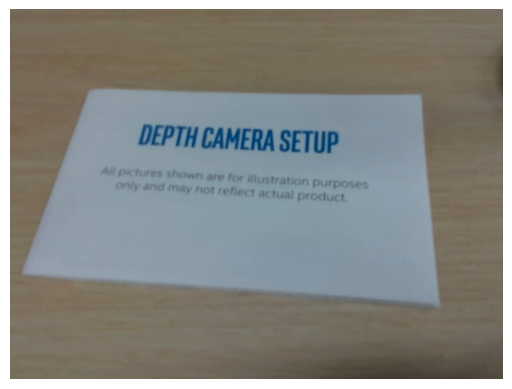

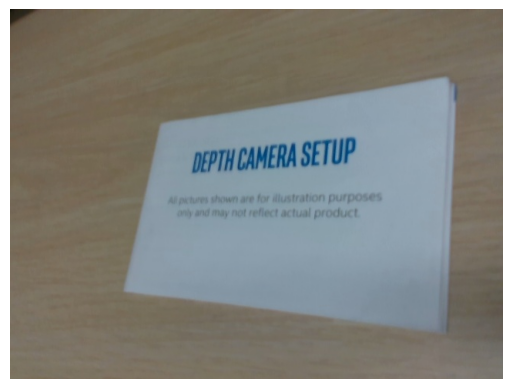

In [ ]:
# Load the image
try:
    img = Image.open('feature_matching1.jpg')
    img_array = np.array(img)
    # Split the image into RGB channels
    if img_array.shape[-1] != 3: # Check if the image has 3 channels (RGB)
      print("Error: The image does not appear to be an RGB image.")

    img2 = Image.open('feature_matching2.jpg')
    img_array2 = np.array(img2)
    print("The captured images")
    plt.axis("off")
    plt.imshow(img_array)
    plt.show()
    plt.axis("off")
    plt.imshow(img_array2)
    plt.show()


except FileNotFoundError:
    print("Error: The file photo.jpg was not found. Please make sure to capture an image first.")
except Exception as e:
    print(f"An error occurred: {e}")

### Convert them into grayscale

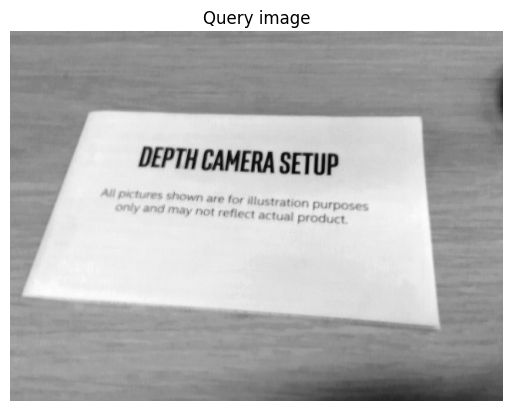

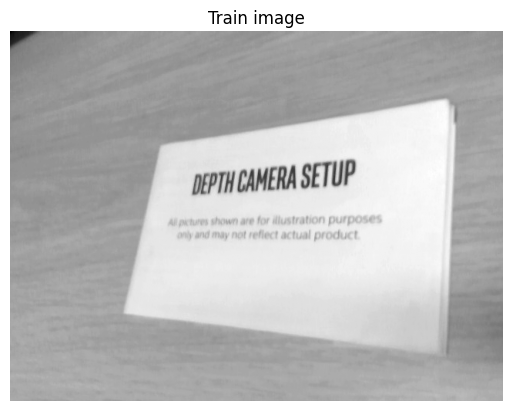

In [ ]:
# Convert the image into gray-scale format
img = Image.open('feature_matching1.jpg')
# Convert the image to grayscale
img_gray = img.convert('L')

# Convert the grayscale image back to a NumPy array for display
img_gray_array1 = np.array(img_gray)

plt.axis("off")
plt.imshow(img_gray_array1, cmap="gray")
plt.title("Query image")
plt.show()

img = Image.open('feature_matching2.jpg')
# Convert the image to grayscale
img_gray = img.convert('L')

# Convert the grayscale image back to a NumPy array for display
img_gray_array2 = np.array(img_gray)

plt.axis("off")
plt.imshow(img_gray_array2, cmap="gray")
plt.title("Train image")
plt.show()

### Extract out the features

In [ ]:
img1 = cv2.imread('feature_matching1.jpg',cv2.IMREAD_GRAYSCALE)          # queryImage
img1_color = cv2.imread('feature_matching1.jpg')
img2 = cv2.imread('feature_matching2.jpg',cv2.IMREAD_GRAYSCALE) # trainImage
img2_color = cv2.imread('feature_matching2.jpg')

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
print("Statistics on the keypoints detecting from SIFT: ")
print("Number of points: " + str(len(kp1)))
print("Data type of the keypoints: " + str(type(kp1[0])))
print("Number of points: " + str(len(kp2)))
print("Data type of the keypoints: " + str(type(kp2[0])))
print("Feature Descriptions: ")
print(des1.shape)
print(des2.shape)
# drawKeypoints(input_image, keypoints, output_image)
img1_sift = cv2.drawKeypoints(img1,kp1,img1_color)

cv2.imshow("Sift features extracted from the first image", img1_sift)
cv2.waitKey(0)
cv2.destroyAllWindows()
print("Image closed")

Statistics on the keypoints detecting from SIFT: 
Number of points: 215
Data type of the keypoints: <class 'cv2.KeyPoint'>
Number of points: 145
Data type of the keypoints: <class 'cv2.KeyPoint'>
Feature Descriptions: 
(215, 128)
(145, 128)
Image closed


### Feature Matching

In [ ]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img_ratio = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv2.imshow("Matched SIFT features w/ ratio testing", img_ratio)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Section 2: Transformations

In [ ]:
### General form
def transform(img1, img2, mapping, **kwargs):

    # Following the conventions on slides
    H, W = img1.shape
    H2, W2 = img2.shape
    result = np.zeros((H2, W2))
    for i in range(H):
        for j in range(W):
            # Extract the pixel coordinates
            x1 = [i, j] # images are input as np arrays, so use [row, column] coordinate

            # Apply the mapping
            x2 = np.floor(mapping(x1, kwargs)).flatten()
            x_new = int(x2[0])
            y_new = int(x2[1])
            # Check the boundary condition
            if x_new > 0 and x_new < H2 and y_new > 0 and y_new < W2:
                # Assign the pixel value to the new image
                result[x_new, y_new] = img1[i, j]
    return result


### Euclidean
Dofs: 3

Formula
$$
\begin{bmatrix}
\cos \theta & -\sin \theta & t_x\\
\sin \theta & \cos \theta & t_y\\
0 & 0 & 1
\end{bmatrix}
$$

Invariant properties: angle, length, area

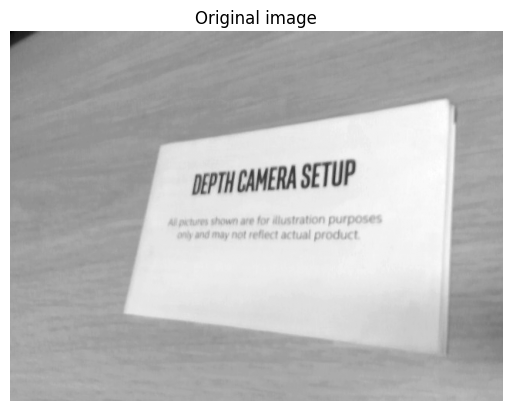

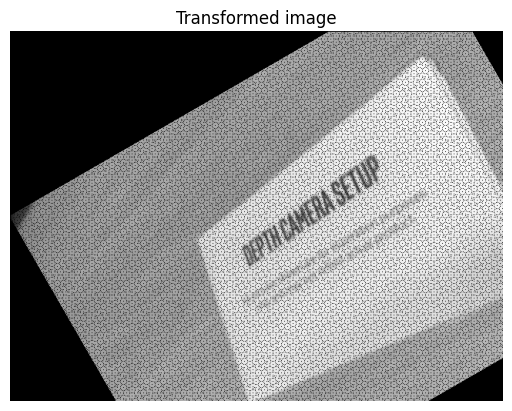

In [ ]:
def euclidean(coords, kwargs):
    theta = kwargs["theta"]
    t = kwargs["t"]
    x = np.array([[coords[0]], [coords[1]], [1]])
    # Formulas for Euclidean transform
    transform = np.array([
        [np.cos(theta), -np.sin(theta), t[0]],
        [np.sin(theta), np.cos(theta), t[1]],
        [0, 0, 1]
    ])
    result_x = transform@x
    return result_x

img_gray_array1 = np.array(img_gray)

plt.axis("off")
plt.imshow(img_gray_array1, cmap="gray")
plt.title("Original image")
plt.show()

img_gray_transform = np.zeros((img_gray_array1.shape[0], img_gray_array1.shape[1]))
theta = np.pi/6
t = np.array([img_gray_array1.shape[0]/2, 0])
img_gray_transform = transform(img_gray_array1, img_gray_transform, euclidean, theta=theta, t=t)

plt.axis("off")
plt.imshow(img_gray_transform, cmap="gray")
plt.title("Transformed image")
plt.show()


### Similarity
Dofs: 4

Formula:
$$
\begin{bmatrix}
\alpha \cos \theta & -\alpha \sin \theta & t_x\\
\alpha \sin \theta & \alpha \cos \theta & t_y\\
0 & 0 & 1
\end{bmatrix}
$$

Invariant properties: length ratio, angle

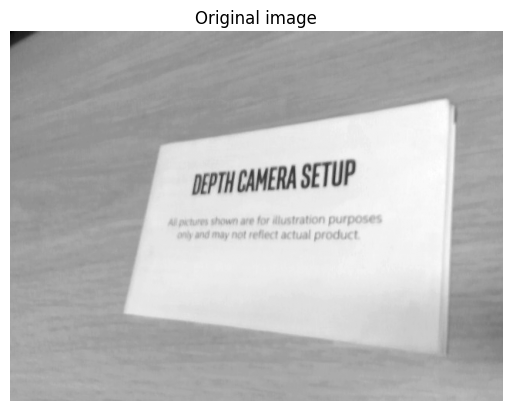

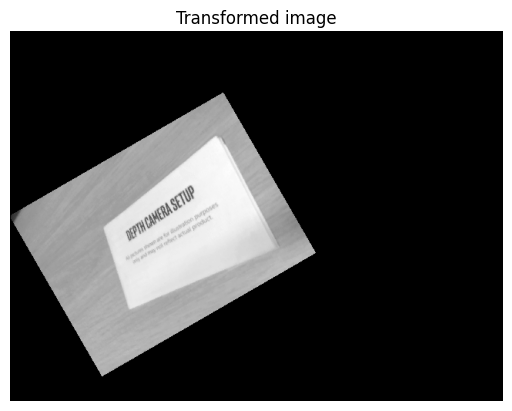

In [ ]:
def similarity(coords, kwargs):
    theta = kwargs["theta"]
    t = kwargs["t"]
    alpha = kwargs["alpha"]
    x = np.array([[coords[0]], [coords[1]], [1]])
    # Formulas for Similarity transform
    transform = np.array([
        [alpha*np.cos(theta), -alpha*np.sin(theta), t[0]],
        [alpha*np.sin(theta), alpha*np.cos(theta), t[1]],
        [0, 0, 1]
    ])
    result_x = transform@x
    return result_x

img_gray_array1 = np.array(img_gray)

plt.axis("off")
plt.imshow(img_gray_array1, cmap="gray")
plt.title("Original image")
plt.show()

img_gray_transform = np.zeros((img_gray_array1.shape[0], img_gray_array1.shape[1]))
theta = np.pi/6
t = np.array([img_gray_array1.shape[0]/2, 0])
alpha = 0.5
img_gray_transform = transform(img_gray_array1, img_gray_transform, similarity, theta=theta, t=t, alpha=alpha)

plt.axis("off")
plt.imshow(img_gray_transform, cmap="gray")
plt.title("Transformed image")
plt.show()

### Affine
Dofs: 6

Formula:
$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13}\\
a_{21} & a_{22} & a_{23}\\
0 & 0 & 1
\end{bmatrix}
$$

Invariant properties: Parallelism, ratio of area, ratio of length

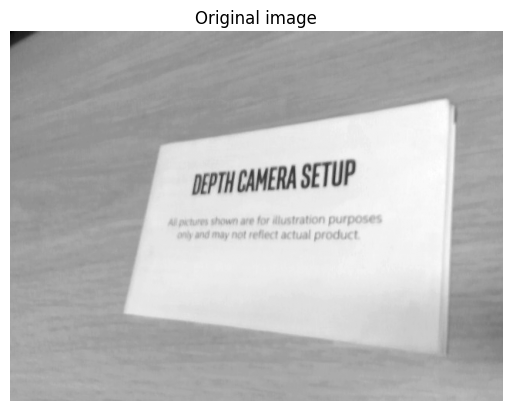

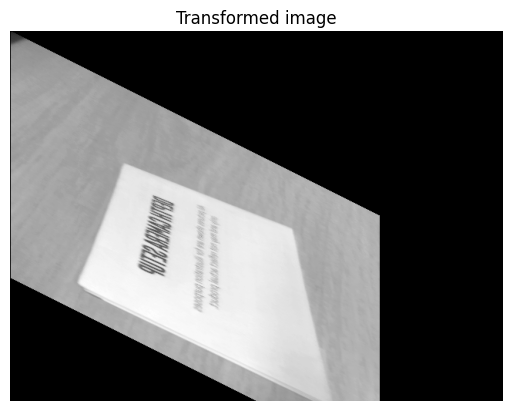

In [ ]:
def affine(coords, kwargs):
    transform = kwargs["affine_transform"]
    x = np.array([[coords[0]], [coords[1]], [1]])
    # Formulas for affine transform
    result_x = transform@x
    return result_x

img_gray_array1 = np.array(img_gray)

plt.axis("off")
plt.imshow(img_gray_array1, cmap="gray")
plt.title("Original image")
plt.show()

img_gray_transform = np.zeros((img_gray_array1.shape[0], img_gray_array1.shape[1]))
affine_transform = np.array([
    [0.5, 0.5, 0],
    [1, 0, 0],
    [0, 0, 1]
])

img_gray_transform = transform(img_gray_array1, img_gray_transform, affine, affine_transform=affine_transform)

plt.axis("off")
plt.imshow(img_gray_transform, cmap="gray")
plt.title("Transformed image")
plt.show()

### Projective
Dofs: 8

Formula:
$$
\begin{bmatrix}
h_{11} & h_{12} & h_{13}\\
h_{21} & h_{22} & h_{23}\\
h_{31} & h_{32} & 1
\end{bmatrix}
$$

Invariant properties: Cross-ratio, Concurrency, Co-linearity

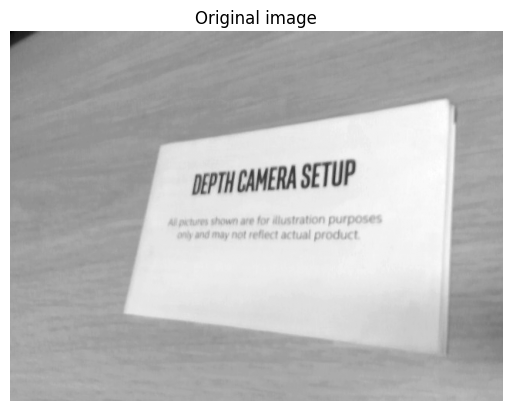

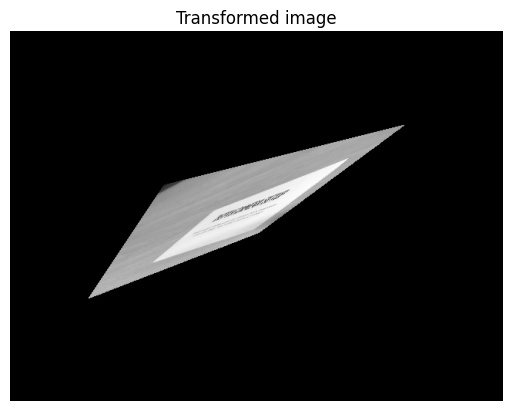

In [ ]:
def projective(coords, kwargs):
    transform = kwargs["projective_transform"]
    x = np.array([[coords[0]], [coords[1]], [1]])
    # Formulas for projective transform
    result_x = transform@x
    z = result_x[2][0]
    result_x = result_x/z
    assert result_x[2][0] == 1
    return result_x

img_gray_array1 = np.array(img_gray)

plt.axis("off")
plt.imshow(img_gray_array1, cmap="gray")
plt.title("Original image")
plt.show()

img_gray_transform = np.zeros((img_gray_array1.shape[0], img_gray_array1.shape[1]))
projective_transform = np.array([
    [1, 0, 200],
    [0, 1, 200],
    [0.002, 0.001, 1]
])

img_gray_transform = transform(img_gray_array1, img_gray_transform, projective, projective_transform=projective_transform)

plt.axis("off")
plt.imshow(img_gray_transform, cmap="gray")
plt.title("Transformed image")
plt.show()

## Section 3: Homography & Image warping

### Display the two images again

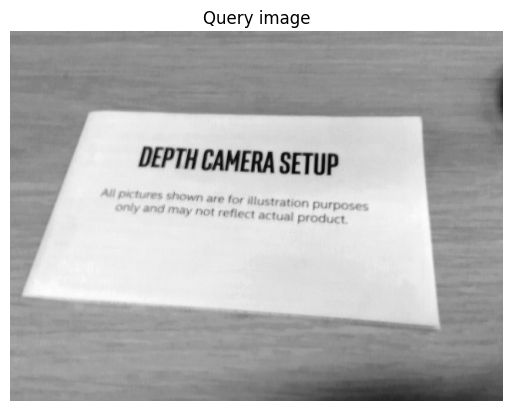

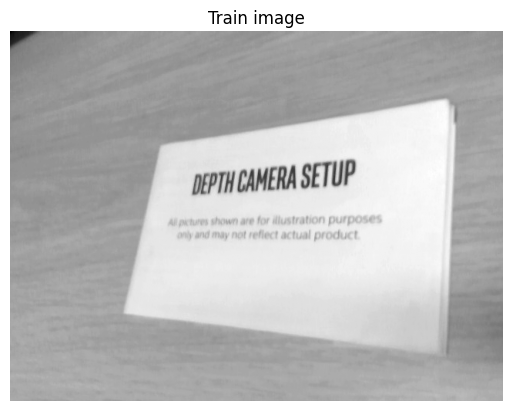

In [ ]:
# Convert the image into gray-scale format
img = Image.open('feature_matching1.jpg')
# Convert the image to grayscale
img_gray = img.convert('L')

# Convert the grayscale image back to a NumPy array for display
img_gray_array1 = np.array(img_gray)

plt.axis("off")
plt.imshow(img_gray_array1, cmap="gray")
plt.title("Query image")
plt.show()

img = Image.open('feature_matching2.jpg')
# Convert the image to grayscale
img_gray = img.convert('L')

# Convert the grayscale image back to a NumPy array for display
img_gray_array2 = np.array(img_gray)

plt.axis("off")
plt.imshow(img_gray_array2, cmap="gray")
plt.title("Train image")
plt.show()

In [ ]:
### Display their matches again

In [ ]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img_ratio = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv2.imshow("Matched SIFT features w/ ratio testing", img_ratio)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Construct the linear system

In [ ]:
# Extract out the coordinates
query_coords = []
train_coords = []

for i in range(len(good)):
    query_point = kp1[good[i][0].queryIdx]
    query_coords.append([query_point.pt[0], query_point.pt[1]])
    train_point = kp2[good[i][0].trainIdx]
    train_coords.append([train_point.pt[0], train_point.pt[1]])

query_coords = np.array(query_coords)
train_coords = np.array(train_coords)

A = []
b = []

# TODO: please manually select good matching points
points_to_select = np.array([
    [258, 165],
    [141, 131],
    [431, 244],
    [217, 175]
])
def dist(v1, v2):
    return (v1[0]-v2[0])**2 + (v1[1]-v2[1])**2
# Build up the linear system
for i in range(query_coords.shape[0]):
    v, u = query_coords[i] # In OpenCV, (x, y) corresponds to the point at column x, row y
    for p_ref in points_to_select:
        if dist([v, u], p_ref) < 100:
            # Only select the "good" matching points
            v_prime, u_prime = train_coords[i]
            A.append([u, v, 1, 0, 0, 0, -u*u_prime, -v*u_prime])
            A.append([0, 0, 0, u, v, 1, -u*v_prime, -v*v_prime])
            b.append(u_prime)
            b.append(v_prime)

A = np.array(A)
b = np.array(b)
print(A.shape)
print(b.shape)

(12, 8)
(12,)


### Find the solution & Construct the homography

In [ ]:
# Find the solution
x = np.linalg.pinv(A.T@A)@A.T@(b.reshape(-1, 1)).flatten()
homo_transform = np.array([
    [x[0], x[1], x[2]],
    [x[3], x[4], x[5]],
    [x[6], x[7], 1]
])
print(homo_transform)

[[ 2.74356684e+00 -6.85347303e-01 -1.99908284e+01]
 [ 1.86064627e+00  3.09079072e-01  1.44119728e+01]
 [ 6.25387395e-03 -2.73556168e-03  1.00000000e+00]]


### Visualization

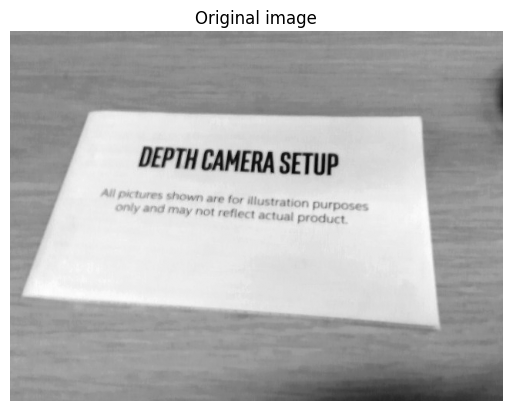

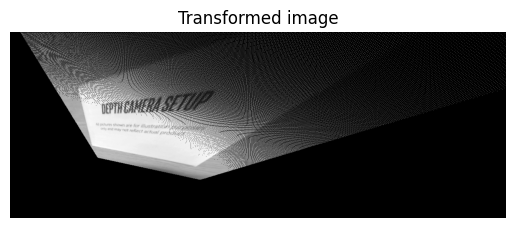

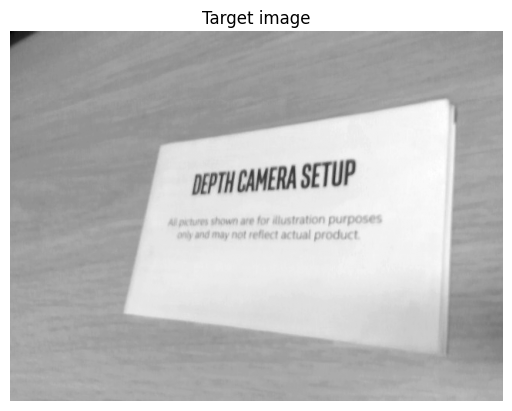

In [ ]:
# Apply the transform
img_gray_transform = np.zeros((img_gray_array1.shape[0], 2 * img_gray_array1.shape[1]))
projective_transform = homo_transform

plt.axis("off")
plt.imshow(img_gray_array1, cmap="gray")
plt.title("Original image")
plt.show()

img_gray_transform = transform(img_gray_array1, img_gray_transform, projective, projective_transform=projective_transform)

plt.axis("off")
plt.imshow(img_gray_transform, cmap="gray")
plt.title("Transformed image")
plt.show()

plt.axis("off")
plt.imshow(img_gray_array2, cmap="gray")
plt.title("Target image")
plt.show()

### Visualization of Homography

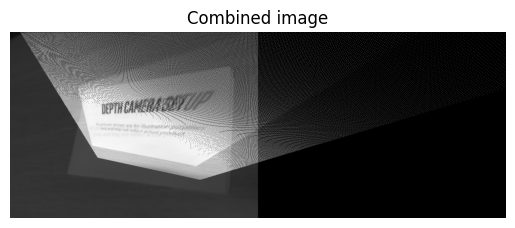

In [ ]:
plt.axis("off")
img_gray_overriding = np.zeros((img_gray_array1.shape[0], 2 * img_gray_array1.shape[1]))
img_gray_overriding[:img_gray_array2.shape[0], :img_gray_array2.shape[1]] = 0.8 * img_gray_array2
img_gray_overriding[:img_gray_transform.shape[0], :img_gray_transform.shape[1]] += 2.0*img_gray_transform
plt.imshow(img_gray_overriding, cmap="gray")
plt.title("Combined image")
plt.show()

### The more points, the better the result?

In [ ]:
# Extract out the coordinates
query_coords = []
train_coords = []

for i in range(len(good)):
    query_point = kp1[good[i][0].queryIdx]
    query_coords.append([query_point.pt[0], query_point.pt[1]])
    train_point = kp2[good[i][0].trainIdx]
    train_coords.append([train_point.pt[0], train_point.pt[1]])

query_coords = np.array(query_coords)
train_coords = np.array(train_coords)

A = []
b = []
# Build up the linear system
for i in range(query_coords.shape[0]):
    v, u = query_coords[i] # In OpenCV, (x, y) corresponds to the point at column x, row y
    v_prime, u_prime = train_coords[i]
    A.append([u, v, 1, 0, 0, 0, -u*u_prime, -v*u_prime])
    A.append([0, 0, 0, u, v, 1, -u*v_prime, -v*v_prime])
    b.append(u_prime)
    b.append(v_prime)

A = np.array(A)
b = np.array(b)

# Find the valid solution
# Find the solution
x = np.linalg.pinv(A.T@A)@A.T@(b.reshape(-1, 1)).flatten()
homo_transform = np.array([
    [x[0], x[1], x[2]],
    [x[3], x[4], x[5]],
    [x[6], x[7], 1]
])
print(homo_transform)



[[-8.07061102e-01 -1.97175826e-01  2.14201098e+02]
 [-1.41430004e+00 -2.93135533e-01  3.58580546e+02]
 [-3.71250262e-03 -9.11902225e-04  1.00000000e+00]]


### Check the validity of the solution to the linear system

In [ ]:
idx = np.random.randint(0, query_coords.shape[0])
u1 = query_coords[idx][1]
v1 = query_coords[idx][0]
u1_prime = train_coords[idx][1]
v1_prime = train_coords[idx][0]
v = np.array([u1, v1, 1])
print("Coordinate of the feature point in original image: ")
print(v)
k = homo_transform@v.reshape(-1,1).flatten()
k = np.array([k[0]/k[2], k[1]/k[2], k[2]/k[2]])
print("Estimated coordinate of the feature point in transformed image: ")
print(k)
print("Coordinate of the matched feature point in target image: ")
print(np.array([u1_prime, v1_prime, 1]))

Coordinate of the feature point in original image: 
[226.90438843 424.34957886   1.        ]
Estimated coordinate of the feature point in transformed image: 
[229.32827089 378.12452971   1.        ]
Coordinate of the matched feature point in target image: 
[244.88995361 418.01629639   1.        ]


### Visualization

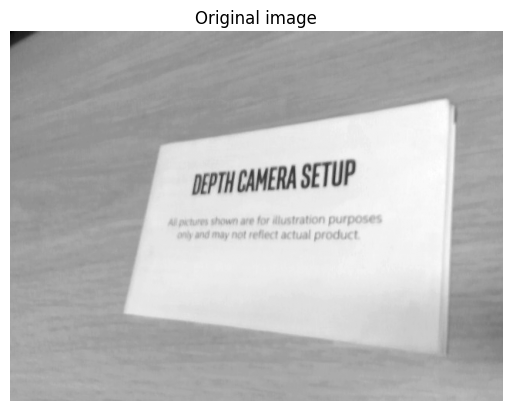

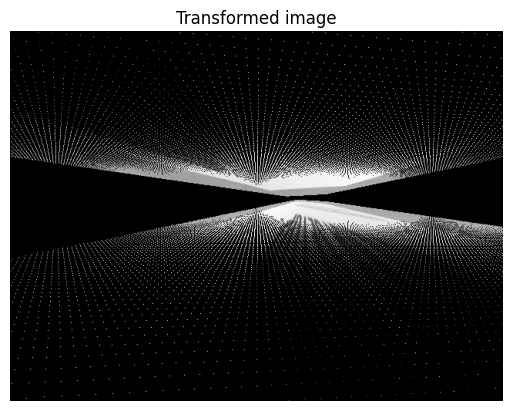

In [ ]:
# Apply the transform
img_gray_transform = np.zeros((img_gray_array1.shape[0], img_gray_array1.shape[1]))
projective_transform = homo_transform

plt.axis("off")
plt.imshow(img_gray_array1, cmap="gray")
plt.title("Original image")
plt.show()

img_gray_transform = transform(img_gray_array1, img_gray_transform, projective, projective_transform=projective_transform)

plt.axis("off")
plt.imshow(img_gray_transform, cmap="gray")
plt.title("Transformed image")
plt.show()

### Next Step: RANSAC

### OpenCV Implementation of Homography(Optional)
Use the built-in functionality to create the stitched image directly
Reference: https://www.geeksforgeeks.org/python/opencv-panorama-stitching/

In [ ]:

image_paths=['feature_matching1.jpg','feature_matching2.jpg']
# initialized a list of images
imgs = []

for i in range(len(image_paths)):
    imgs.append(cv2.imread(image_paths[i]))



stitchy=cv2.Stitcher.create()
(dummy,output)=stitchy.stitch(imgs)

if dummy != cv2.STITCHER_OK:
  # checking if the stitching procedure is successful
  # .stitch() function returns a true value if stitching is
  # done successfully
    print("stitching ain't successful")
else:
    print('Your Panorama is ready!!!')

# final output
cv2.imshow('final result',output)

cv2.waitKey(0)

cv2.destroyAllWindows()

Your Panorama is ready!!!


Also, a step-by-step of image warping & stitching:
https://www.geeksforgeeks.org/computer-vision/image-stitching-with-opencv/